In [1]:
import torch
from torchvision.models import DenseNet121_Weights
from torchvision.models import densenet121
from torchvision import transforms
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torch.utils.data import random_split
from CustomDataset import CustomDataset
import matplotlib.pyplot as plt
import random
from PIL import Image
from tqdm.auto import tqdm
import os

In [2]:
#Device Agnostic Code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [3]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomInvert(),
    transforms.ToTensor()
])

In [4]:

root_dir = r'Dataset\Image\images_001'
csv_file = r'Dataset\Data_entry_2017.csv'

dataset = CustomDataset(csv_file=csv_file, root_dir=root_dir,transform=transform)

dataset.show()

#Splittig Data
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# Create datasets and loaders

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



           Image Index  Pneumonia  Consolidation  Atelectasis  Emphysema  \
0     00000001_000.png          0              0            0          0   
1     00000001_001.png          0              0            0          1   
2     00000001_002.png          0              0            0          0   
3     00000002_000.png          0              0            0          0   
4     00000003_000.png          0              0            0          0   
...                ...        ...            ...          ...        ...   
2995  00000798_007.png          0              0            0          0   
2996  00000798_008.png          0              0            0          0   
2997  00000798_009.png          0              0            0          0   
2998  00000798_010.png          0              0            0          0   
2999  00000798_011.png          0              0            0          0   

      Infiltration  Effusion  Edema  Hernia  Cardiomegaly  Pneumothorax  \
0           

In [5]:


# # Define the label columns
# label_columns = dataset.classes

# # Get a random index from the training dataset
# # random_index = random.randint(0, len(dataset) - 1)
# random_img = random.choice(os.listdir('Dataset\Image\images_001\images'))
# print(random_img)

# sample_image = None

# # Check if the random index exists in the dataset
# if random_img in dataset.data:
#     # Retrieve the image and labels for the random index
#     sample_image, sample_labels = dataset.data.loc[random_img]

#     # Check if 'ID' column exists in the dataset
#     if 'Image Index' in label_columns:
#         print(f"Image Index: {sample_labels[label_columns.index('Image Index')]}")

#     sample_image = sample_image.permute(1,2,0)
#     print(sample_labels)
# else:
#     print(f"{random_img} does not exist in the dataset.")

# # Display the image
# plt.imshow(sample_image)
# plt.title(f"Image Index: {random_img + 1}")
# plt.show()

# # Print labels with value 1
# # print(f"Labels for Image Index {random_index + 1} with value 1:")
# # for column, value in zip(label_columns, sample_labels):
# #     if value == 1:
# #         print(f"{column}: {value}")

In [6]:
random_img = random.choice(os.listdir('Dataset\Image\images_001'))



In [7]:
#Hyper Parmaeters
lr = 0.01
epochs = 5



In [16]:
# model = densenet121(weights = DenseNet121_Weights.DEFAULT)
model = densenet121(pretrained = True)
pretrained_weights = model.features.conv0.weight.clone()

# Create a new layer with 1 input channel
model.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Copy over the weights from the pre-trained layer
# We take the mean over the channel dimension
model.features.conv0.weight.data = pretrained_weights.mean(dim=1, keepdim=True)

model.to(device)

c:\Users\swast\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\swast\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [17]:
#Loss_fn and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = lr)

In [18]:
# Training Loop 
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}/{epochs}")
    loss_values = []
    
    for batch_idx,(img,label) in enumerate(tqdm(train_loader)):
        
        pred = model(img)  # Corrected argument
        
        loss = loss_fn(pred,label)
        loss_values.append(loss.item())  # Added missing argument
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    
    print(f"Loss: {loss.item()}")
    

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0/5


  0%|          | 0/75 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x000002746AC8BD90>
Traceback (most recent call last):
  File "c:\Users\swast\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\std.py", line 1149, in __del__
    self.close()
  File "c:\Users\swast\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\notebook.py", line 271, in close
    def close(self):
KeyboardInterrupt: 


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [20]:
#Accuracy fn

def accuracy(loader,model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device = device)
            y = y.to(device = device)
            
            scores = model(x)
            _,predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")
        
    model.train()


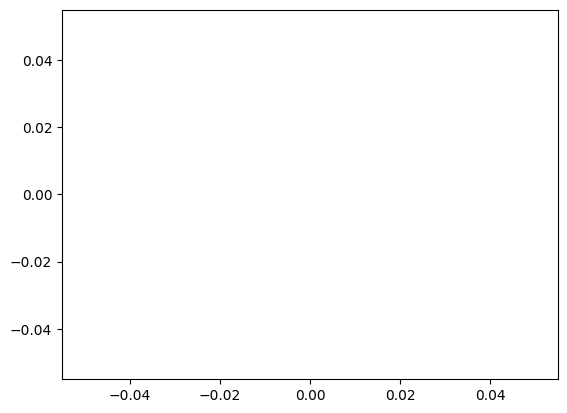

In [21]:
#Plotting Loss
plt.plot(loss_values);


In [24]:
#Saving Model
PATH = 'Model/XRaydensenet.pth'
torch.save(model.state_dict(),f = PATH)
print(f"Model Succesffully Saved at {PATH}")

Model Succesffully Saved at Model/XRaydensenet.pth
